# TIME SERIES FORECASTING

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from math import sqrt 

import statsmodels.api as sma
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.api import SimpleExpSmoothing           #for single exponential smoothing
from statsmodels.tsa.api import Holt                         #for double exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing #for triple exponential smoothing


In [2]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 

In [3]:
#! pip install pmdarima

In [3]:
### Reading  data into dataframe
data=pd.read_excel("Praxis workshop_MEV_TF.xlsx")

In [4]:
data

,Date,Real GDP,Unemployment Rate,CPI - All Items,Real Disposable Income,Nominal GDP,Nominal Disposable Income,Dow Jones Total Stock Market Index,World Oil Price
0,2004-01-28,13555.213297,5.785714,185.664835,9857.438242,11875.276923,8708.950110,10881.316703,30.253003
1,2004-02-28,13580.006703,5.744286,186.165165,9880.271758,11929.953077,8750.279890,10957.733297,31.060327
2,2004-03-28,13606.510000,5.700000,186.700000,9904.680000,11988.400000,8794.460000,11039.420000,31.923330
3,2004-04-28,13639.391319,5.667033,187.184615,9936.849231,12052.026374,8843.603956,11074.091429,33.084871
4,2004-05-28,13673.368681,5.632967,187.685385,9970.090769,12117.773626,8894.386044,11109.918571,34.285129
...,...,...,...,...,...,...,...,...,...
223,2022-08-31,19065.612174,4.220217,274.408913,14297.932174,23913.644130,17793.190217,34590.019130,64.382391
224,2022-09-30,19092.110000,4.230000,274.960000,14317.080000,23982.980000,17842.400000,34721.530000,64.490000
225,2022-10-31,19120.138043,4.230000,275.536196,14336.121413,24057.127283,17892.582935,34859.021739,64.601196
226,2022-11-30,19147.261956,4.230000,276.093804,14354.548587,24128.882717,17941.147065,34992.078261,64.708804


In [5]:
data = data.drop(["Unemployment Rate","World Oil Price","CPI - All Items","Real Disposable Income","Nominal GDP","Nominal Disposable Income","Dow Jones Total Stock Market Index"],axis=1)

In [6]:
#Convert object into dateformat
data.Date = pd.to_datetime(data.Date)

In [7]:
data.dtypes

Date        datetime64[ns]
Real GDP           float64
dtype: object

In [8]:
data

,Date,Real GDP
0,2004-01-28,13555.213297
1,2004-02-28,13580.006703
2,2004-03-28,13606.510000
3,2004-04-28,13639.391319
4,2004-05-28,13673.368681
...,...,...
223,2022-08-31,19065.612174
224,2022-09-30,19092.110000
225,2022-10-31,19120.138043
226,2022-11-30,19147.261956


In [9]:
# train - from jan 2004 to june 2017
train=data.iloc[:162]
train.tail()

,Date,Real GDP
157,2017-02-28,16885.390889
158,2017-03-31,16903.240000
159,2017-04-30,16945.388352
160,2017-05-31,16988.941648
161,2017-06-30,17031.090000


In [10]:
# validation(OOT) - from june 2017 to Dec 2018
valid=data.iloc[162:180]
y_hat=valid.copy()

In [16]:
# Test - from Dec 2018 to Dec 2022
test=data.iloc[180:]
test.head(5)

,Date,Real GDP
180,2019-01-31,17762.639556
181,2019-02-28,17794.080444
182,2019-03-31,17828.890000
183,2019-04-30,17862.400989
184,2019-05-31,17897.029011


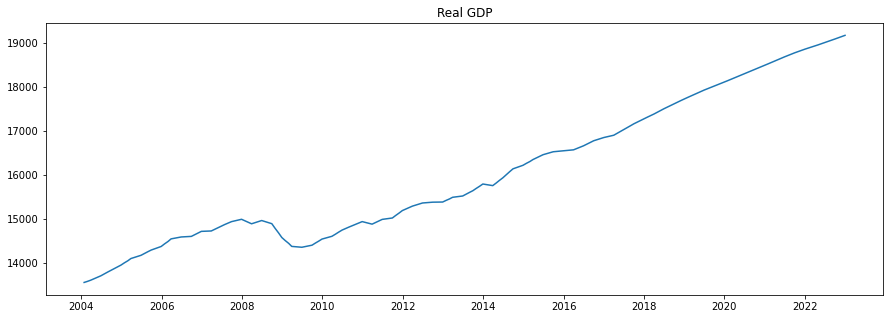

In [12]:
#plotting the entire data
plt.figure(figsize=(15,5))
plt.plot(data['Date'],data['Real GDP'])
plt.title('Real GDP')
plt.show()

### Naive Approach

In [13]:
y_hat['Naive_Forecast'] = train.iloc[len(train)-1,1]
y_hat.head()

,Date,Real GDP,Naive_Forecast
162,2017-07-31,17075.837826,17031.09
163,2017-08-31,17120.585652,17031.09
164,2017-09-30,17163.890000,17031.09
165,2017-10-31,17202.542283,17031.09
166,2017-11-30,17239.947717,17031.09


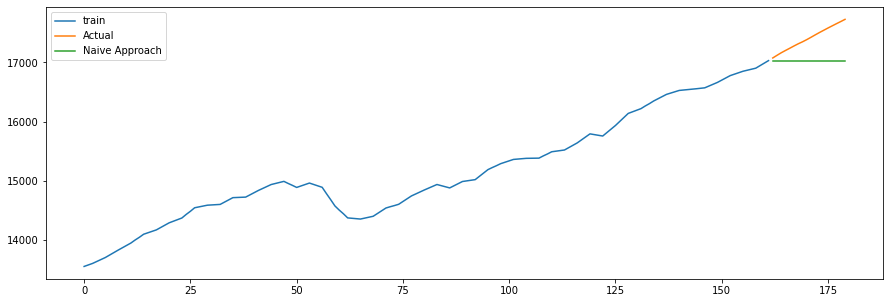

In [14]:
plt.figure(figsize=(15,5))
plt.plot(train['Real GDP'],label="train")
plt.plot(y_hat['Real GDP'],label="Actual")
plt.plot(y_hat["Naive_Forecast"],label="Naive Approach")
plt.legend()
plt.show()

In [17]:
print("MAPE: ",mean_absolute_percentage_error(y_hat["Real GDP"],y_hat["Naive_Forecast"]))
print("RMSE: ",sqrt(mean_squared_error(y_hat["Real GDP"],y_hat["Naive_Forecast"])))

MAPE:  0.021537786623675715
RMSE:  425.73670858495205


### Average Method

In [19]:
y_hat['Average_Model'] = np.round(train["Real GDP"].mean(),2)
y_hat.head()

,Date,Real GDP,Naive_Forecast,Average_Model
162,2017-07-31,17075.837826,17031.09,15178.46
163,2017-08-31,17120.585652,17031.09,15178.46
164,2017-09-30,17163.890000,17031.09,15178.46
165,2017-10-31,17202.542283,17031.09,15178.46
166,2017-11-30,17239.947717,17031.09,15178.46


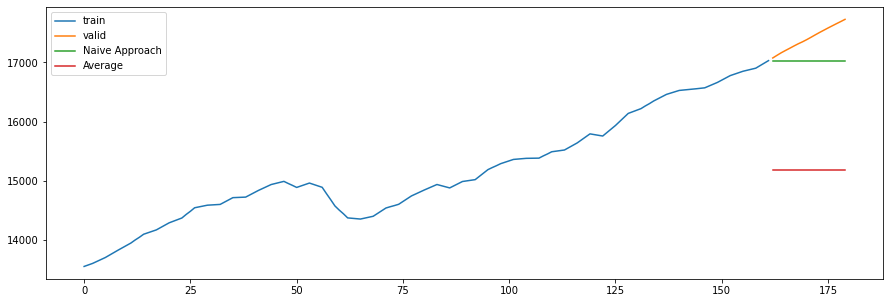

In [20]:
plt.figure(figsize=(15,5))
plt.plot(train['Real GDP'],label="train")
plt.plot(y_hat['Real GDP'],label="valid")
plt.plot(y_hat["Naive_Forecast"],label="Naive Approach")
plt.plot(y_hat["Average_Model"],label="Average")
plt.legend()
plt.show()

In [21]:
print("MAPE: ",mean_absolute_percentage_error(y_hat["Real GDP"],y_hat["Average_Model"]))
print("RMSE: ",sqrt(mean_squared_error(y_hat["Real GDP"],y_hat["Average_Model"])))

MAPE:  0.12797421848842308
RMSE:  2238.4927821064402


### Drift Method

In [22]:
y_hat['Drift'] = np.nan
y_hat.head()

,Date,Real GDP,Naive_Forecast,Average_Model,Drift
162,2017-07-31,17075.837826,17031.09,15178.46,NaN
163,2017-08-31,17120.585652,17031.09,15178.46,NaN
164,2017-09-30,17163.890000,17031.09,15178.46,NaN
165,2017-10-31,17202.542283,17031.09,15178.46,NaN
166,2017-11-30,17239.947717,17031.09,15178.46,NaN


In [23]:
y_hat.head()

,Date,Real GDP,Naive_Forecast,Average_Model,Drift
162,2017-07-31,17075.837826,17031.09,15178.46,NaN
163,2017-08-31,17120.585652,17031.09,15178.46,NaN
164,2017-09-30,17163.890000,17031.09,15178.46,NaN
165,2017-10-31,17202.542283,17031.09,15178.46,NaN
166,2017-11-30,17239.947717,17031.09,15178.46,NaN


In [24]:
for i in range(len(y_hat)):
    y_hat.iloc[i,4] = np.round(train.iloc[-1,1]+((i+1)*(train.iloc[-1,1] - train.iloc[0,1])/(len(train)-1)),2)

In [25]:
y_hat.head()

,Date,Real GDP,Naive_Forecast,Average_Model,Drift
162,2017-07-31,17075.837826,17031.09,15178.46,17052.68
163,2017-08-31,17120.585652,17031.09,15178.46,17074.27
164,2017-09-30,17163.890000,17031.09,15178.46,17095.86
165,2017-10-31,17202.542283,17031.09,15178.46,17117.45
166,2017-11-30,17239.947717,17031.09,15178.46,17139.04


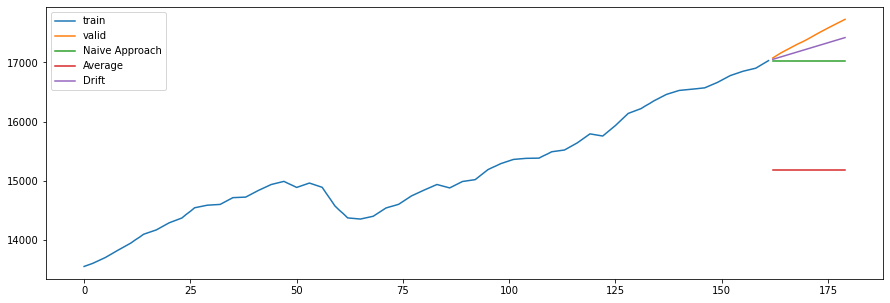

In [26]:
plt.figure(figsize=(15,5))
plt.plot(train["Real GDP"],label="train")
plt.plot(y_hat["Real GDP"],label="valid")
plt.plot(y_hat["Naive_Forecast"],label="Naive Approach")
plt.plot(y_hat["Average_Model"],label="Average")
plt.plot(y_hat["Drift"],label="Drift")
plt.legend()
plt.show()

In [27]:
print("MAPE: ",mean_absolute_percentage_error(y_hat["Real GDP"],y_hat["Drift"]))
print("RMSE: ",sqrt(mean_squared_error(y_hat["Real GDP"],y_hat["Drift"])))

MAPE:  0.009827575390617613
RMSE:  192.14042515514652


In [27]:
#Decomposing the time series

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
result=seasonal_decompose(train["Real GDP"], model='multiplicable', period=12)
result

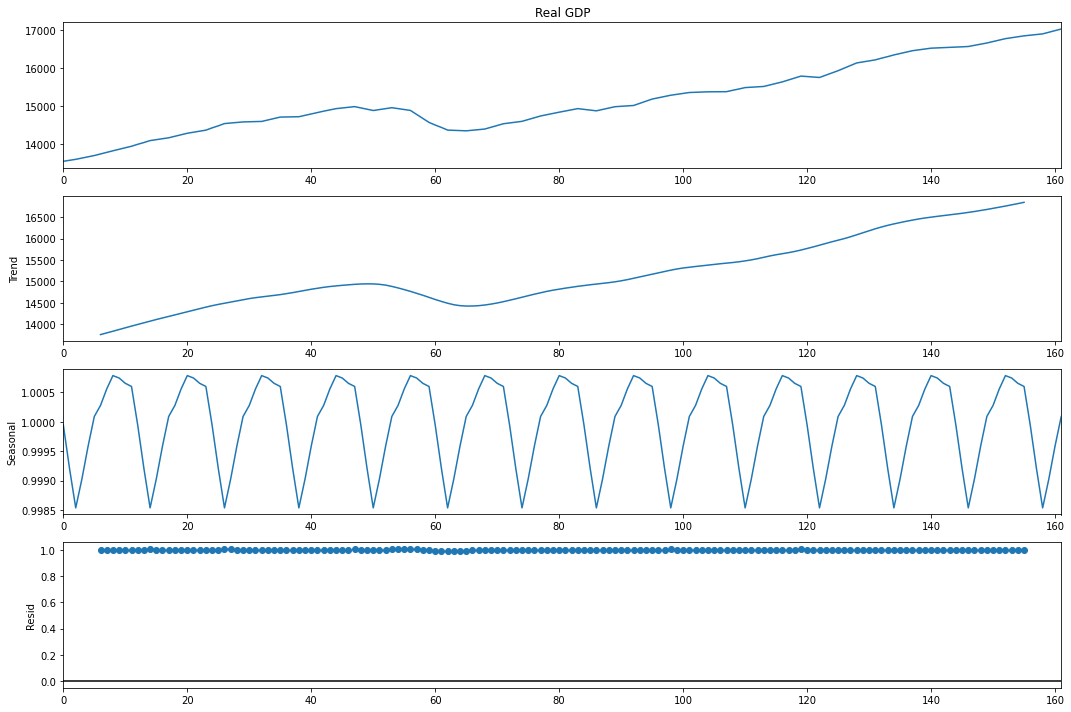

In [30]:
from pylab import rcParams
rcParams['figure.figsize']=15,10

result.plot();

# Advance Methods

### Single Exponential Smoothing

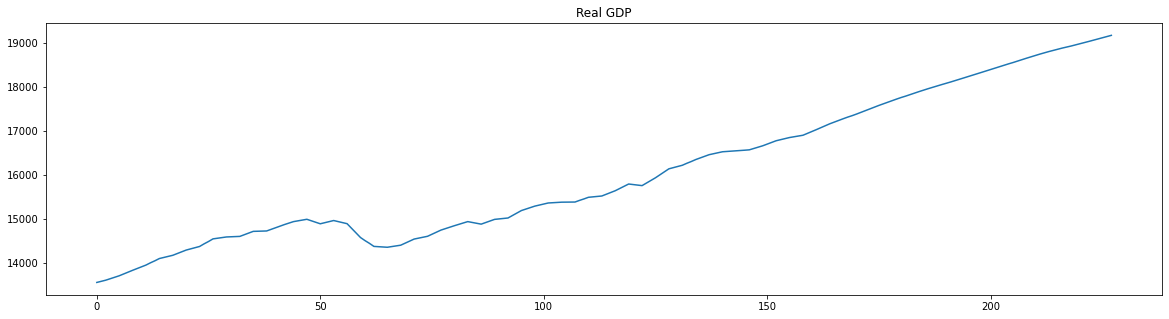

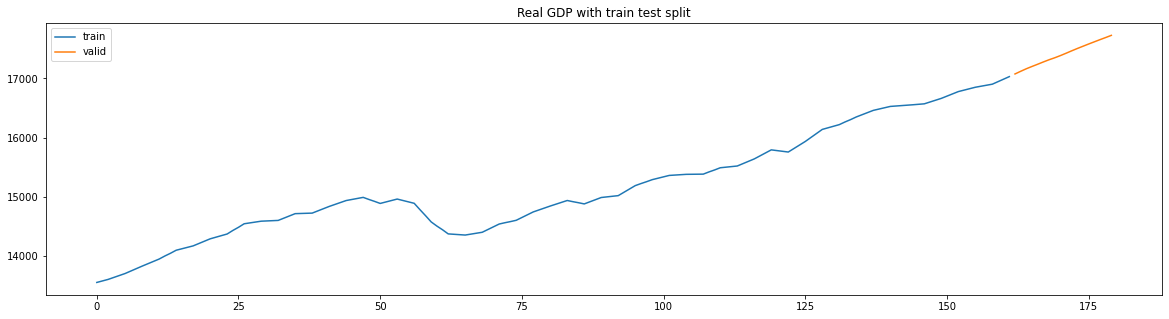

optimal alpha chosen: 0.995


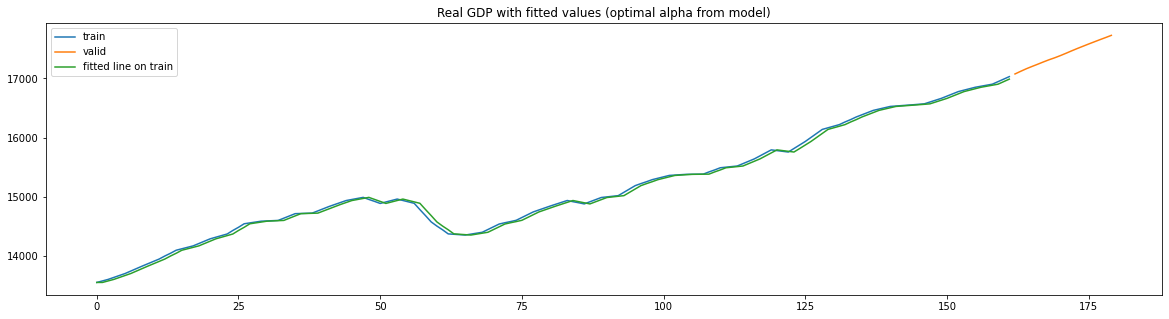

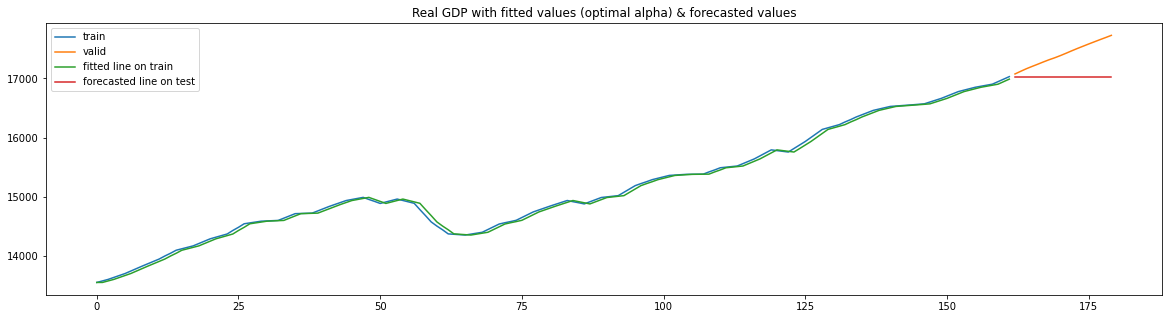

MAPE for model with optimal alpha::  0.02154995691896504
RMSE for model with optimal alpha:  425.92436972783753


,alpha,mpe
99,0.99,0.021562
98,0.98,0.021587
97,0.97,0.021613
96,0.96,0.021639
95,0.95,0.021665
...,...,...
4,0.04,0.059866
3,0.03,0.071220
2,0.02,0.090283
1,0.01,0.127924


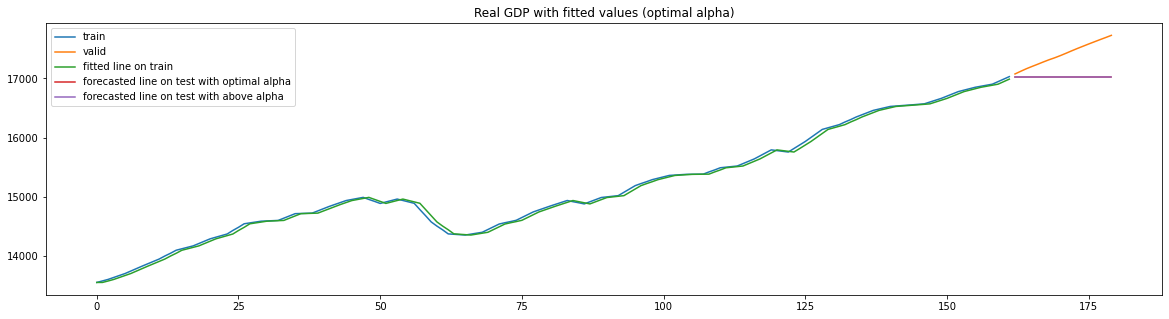

MAPE of Single Exponential Smoothing 0.02156225414961193


In [31]:
#plotting the entire data
plt.figure(figsize=(20,5))
plt.plot(data["Real GDP"])
plt.title("Real GDP")
plt.show()

#splitting into train & test
train=data.iloc[:162]
valid=data.iloc[162:180]
y_hat = valid.copy()

#plotting data after train test split
plt.figure(figsize=(20,5))
plt.plot(train["Real GDP"],label='train')
plt.plot(valid["Real GDP"],label='valid')
plt.title("Real GDP with train test split")
plt.legend()
plt.show()

# fitting SES model with optimal alpha
fitx = SimpleExpSmoothing(np.asarray(train["Real GDP"])).fit(optimized=True)
print('optimal alpha chosen:', fitx.model.params['smoothing_level'])

#plotting data with fitted values
plt.figure(figsize=(20,5))
plt.plot(train["Real GDP"],label='train')
plt.plot(valid["Real GDP"],label='valid')
plt.plot(fitx.fittedvalues, label = 'fitted line on train')
plt.title('Real GDP with fitted values (optimal alpha from model)')
plt.legend()
plt.show()

#forecasting based on optimal model
y_hat['SES Forecasted Values'] = fitx.forecast(len(y_hat))
y_hat

#plotting with fitted & forecasted values
plt.figure(figsize=(20,5))
plt.plot(train["Real GDP"],label='train')
plt.plot(valid["Real GDP"],label='valid')
plt.plot(fitx.fittedvalues, label = 'fitted line on train')
plt.plot(y_hat['SES Forecasted Values'], label = 'forecasted line on test')
plt.title('Real GDP with fitted values (optimal alpha) & forecasted values')
plt.legend()
plt.show()

# calculating RMSE and Mape of the forecast on test data
rms = sqrt(mean_squared_error(valid["Real GDP"], y_hat['SES Forecasted Values'])) 
mape = mean_absolute_percentage_error(y_hat["Real GDP"],y_hat["SES Forecasted Values"])
print("MAPE for model with optimal alpha:: ", mape)
print('RMSE for model with optimal alpha: ', rms)

#calculating the best alpha value which provides the lowest rmse on forecasted values
mpe = {}
cols = ['alpha', 'mpe']
for i in np.arange(0,1,0.01):
    fit2 = SimpleExpSmoothing(np.asarray(train["Real GDP"])).fit(smoothing_level=i, optimized=False)
    y_hat['SES Forecasted Values with mentioned alpha'] = fit2.forecast(len(y_hat))
    mpe[i] = mean_absolute_percentage_error(valid["Real GDP"],y_hat["SES Forecasted Values with mentioned alpha"])
    
df = pd.DataFrame(list(mpe.items()),columns = ['alpha','mpe']) 
display(df.sort_values(by = 'mpe'))

least_alpha = df.sort_values(by = 'mpe').iloc[0][0]

#fitting model using above alpha
fit3 = SimpleExpSmoothing(np.asarray(train["Real GDP"])).fit(smoothing_level=least_alpha, optimized=False)
y_hat['SES Forecasted Values with mentioned alpha'] = fit3.forecast(len(y_hat))

#plotting with forecasted values using optimal alpha & above alpha
plt.figure(figsize=(20,5))
plt.plot(train["Real GDP"],label='train')
plt.plot(valid["Real GDP"],label='valid')
plt.plot(fit3.fittedvalues, label = 'fitted line on train')
plt.plot(y_hat['SES Forecasted Values'], label = 'forecasted line on test with optimal alpha')
plt.plot(y_hat['SES Forecasted Values with mentioned alpha'], label = 'forecasted line on test with above alpha')
plt.title('Real GDP with fitted values (optimal alpha)')
plt.legend()
plt.show()

#final rmse
mpe = mean_absolute_percentage_error(valid["Real GDP"],y_hat["SES Forecasted Values with mentioned alpha"])

print("MAPE of Single Exponential Smoothing",mpe)

### Double Exponential Smoothing

In [32]:
#finding aplha using for loop
alpha=np.round(np.arange(0, 1, 0.01).tolist(),2)
beta=np.round(np.arange(0, 1, 0.01).tolist(),2)

mpe=[]
mpe_ij=[]

for i in alpha:
    for j in beta:
        fit = Holt(np.asanyarray(train["Real GDP"])).fit(smoothing_level=i, smoothing_slope=j, optimized=False)
        
        mpe_train = np.round(mean_absolute_percentage_error(train["Real GDP"],fit.fittedvalues))
        mpe.append((mpe_train))
        mpe_ij.append((i,j,mpe_train))
#print(rmse)
np.argsort(mpe) #sort it ascending order

array([   0, 6663, 6664, ..., 3336, 3329, 9999], dtype=int64)

In [33]:
mpe_ij[9999] #index with min rmse with resp alpha and beta

(0.99, 0.99, 0.0)

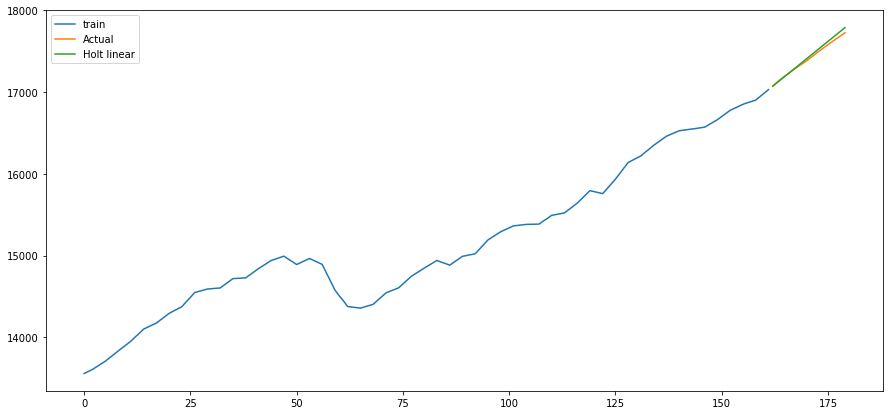

MAPE of Double Exponential Smoothing(Holt linear) 0.0015


In [35]:
# using Holt's linear model predict for valid set
y_hat1 = valid.copy()
fit = Holt(np.asanyarray(train["Real GDP"])).fit(smoothing_level=0.99, smoothing_slope=0.99, optimized=True)
y_hat1['Holt_linear'] = fit.forecast(len(valid))
y_hat1.head()

# plot the forecast
plt.figure(figsize=(15,7))
plt.plot(train["Real GDP"], label='train')
plt.plot(valid["Real GDP"], label='Actual')
plt.plot(y_hat1['Holt_linear'], label='Holt linear')
plt.legend(loc='best')
plt.show()

# compute the error
mape=np.round(mean_absolute_percentage_error(valid["Real GDP"],y_hat1['Holt_linear']),4)

print("MAPE of Double Exponential Smoothing(Holt linear)",mape)

# Triple Exponential Smoothing

In [36]:
min_rmse=1000000

In [37]:
s_level=np.linspace(0,1,10)
s_slope=np.linspace(0,1,10)
d_trend=np.linspace(0,1,10)
s_seasonal=np.linspace(0,1,10)

In [38]:
# for sp in range(2,16):
#     for sl in s_level:
#         for ssl in s_slope:
#             for dt in d_trend:
#                 for ss in s_seasonal:
#                     model = ExponentialSmoothing(np.asarray(train["Real GDP"]), seasonal_periods=sp, trend='add',damped_trend=True, seasonal='mul')
#                     fit1 = model.fit(smoothing_level=sl, smoothing_slope=ssl,damping_trend=dt, smoothing_seasonal=ss, optimized=False)
#                     y_hat['TES_add_mul'] = fit1.forecast(len(valid))
#                     rmse=sqrt(mean_squared_error(valid["Real GDP"], y_hat['TES_add_mul']))
#                     if rmse<min_rmse:
#                         print("\nseasonal_period:{},smoothing_level:{},smoothing_slope:{},damping_trend:{},smoothing_seasonal:{}".format(sp,sl,ssl,dt,ss))
#                         print("rmse: ",rmse)
#                         min_rmse=rmse

In [39]:
# The best parameters.
model = ExponentialSmoothing(np.asarray(train["Real GDP"]), seasonal_periods=5, trend='add',damped_trend=True, seasonal='mul')
fit1 = model.fit(smoothing_level=0.2222222222222222, smoothing_slope=0.0,damping_trend=1, smoothing_seasonal=0.1111111111111111, optimized=False)
y_hat['TES_add_mul'] = fit1.forecast(len(valid))
y_hat.head()

,Date,Real GDP,SES Forecasted Values,SES Forecasted Values with mentioned alpha,TES_add_mul
162,2017-07-31,17075.837826,17030.878164,17030.664119,17078.450177
163,2017-08-31,17120.585652,17030.878164,17030.664119,17118.132664
164,2017-09-30,17163.890000,17030.878164,17030.664119,17159.164683
165,2017-10-31,17202.542283,17030.878164,17030.664119,17196.698695
166,2017-11-30,17239.947717,17030.878164,17030.664119,17233.228106


In [40]:
# Check the RMSE , MAE and MAPE, The values are lower than our benchmark model

In [41]:
rmse=sqrt(mean_squared_error(valid["Real GDP"], y_hat['TES_add_mul']))
mae=(mean_absolute_error(valid["Real GDP"], y_hat['TES_add_mul']))
mape=(mean_absolute_percentage_error(valid["Real GDP"], y_hat['TES_add_mul']))
print("Triple Exponential Smoothing rmse,mae,mape: ",rmse,mae,mape)

Triple Exponential Smoothing rmse,mae,mape:  5.196135189409755 4.566073269272238 0.0002624385588405984


In [42]:
# Plotting the forecast on along with Test Data

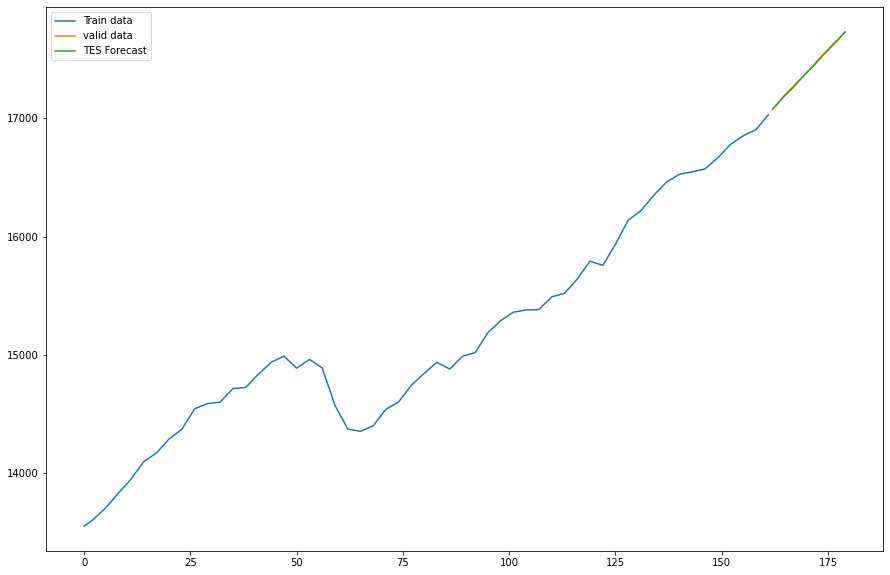

In [43]:
plt.figure(figsize=(15,10))
plt.plot(train["Real GDP"],label="Train data")
plt.plot(valid["Real GDP"],label="valid data")

plt.plot(y_hat["TES_add_mul"],label="TES Forecast")

plt.legend()

# ADFULLER Test to Check for Non-Stationarity

In [44]:
result=adfuller(train["Real GDP"])
result

(0.0768482311083353,
 0.9644444019331854,
 7,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1276.726461912024)

In [45]:
result[0]

0.0768482311083353

In [46]:
result[4]

{'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}

In [47]:
result=adfuller(train["Real GDP"])
print("critical values",result[4])
print("ADF Stat: ",result[0])
if result[0]<result[4]['5%']:
    print("Stationery")
else:
    print("Not Stationery")

critical values {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}
ADF Stat:  0.0768482311083353
Not Stationery


In [48]:
# Checking significance of the coefficients of the number of lag terms through pacf, or on other words the order of AR

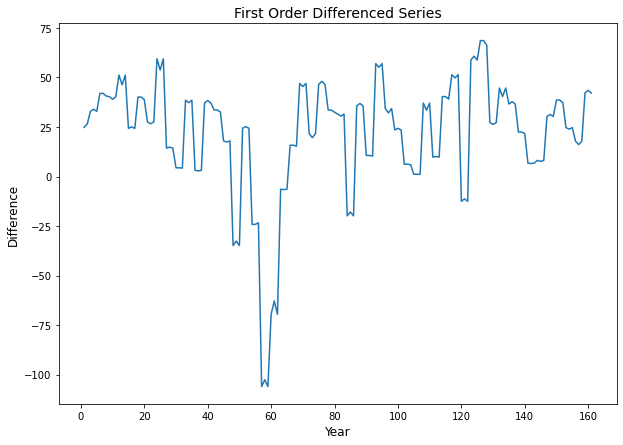

In [49]:
# Change for (t)th day is----- for (t)th day minus Close for (t-1)th day.
train_diff = train["Real GDP"].diff()

# Plot the Change
plt.figure(figsize=(10, 7))
plt.plot(train_diff)
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.show()

In [50]:
train_diff.dropna(inplace=True)

In [51]:
train_diff

1      24.793407
2      26.503297
3      32.881319
4      33.977363
5      32.881319
         ...    
157    16.121778
158    17.849111
159    42.148352
160    43.553297
161    42.148352
Name: Real GDP, Length: 161, dtype: float64

In [52]:
result=adfuller(train_diff)
print("critical values",result[4])
print("ADF Stat: ",result[0])
if result[0]<result[4]['5%']:
    print("Stationery")
else:
    print("Not Stationery")

critical values {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}
ADF Stat:  -2.859245310916092
Not Stationery


In [53]:
result=adfuller(train_diff)
result

(-2.859245310916092,
 0.05029661767715067,
 6,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1266.341641454558)

In [54]:
train_diff2 = train_diff.diff()

In [55]:
train_diff2.dropna(inplace=True)

In [56]:
train_diff2

2       1.709890
3       6.378022
4       1.096044
5      -1.096044
6       9.096725
         ...    
157    -1.727333
158     1.727333
159    24.299240
160     1.404945
161    -1.404945
Name: Real GDP, Length: 160, dtype: float64

In [57]:
result=adfuller(train_diff2)
print("critical values",result[4])
print("ADF Stat: ",result[0])
if result[0]<result[4]['5%']:
    print("Stationery")
else:
    print("Not Stationery")

critical values {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}
ADF Stat:  -7.26767033224059
Stationery


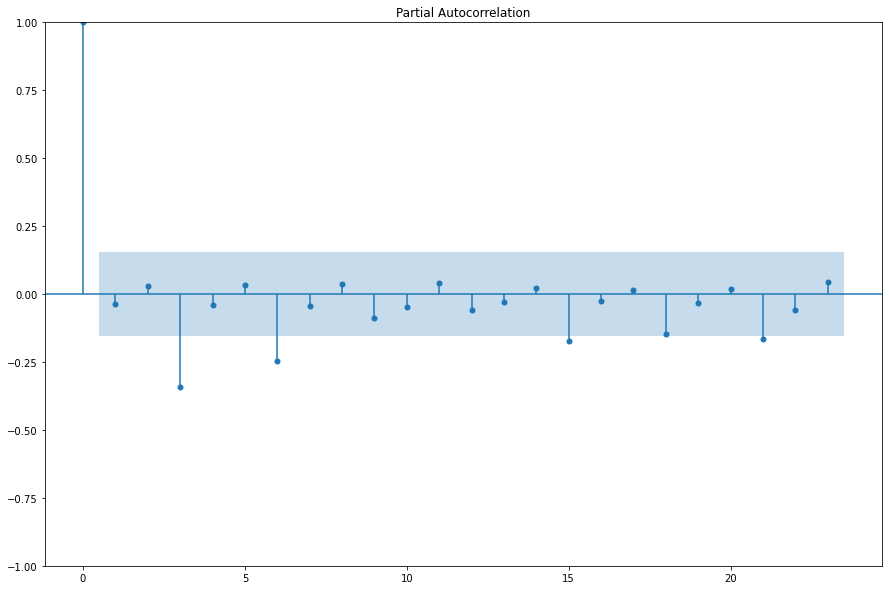

In [58]:
plot_pacf(train_diff2, alpha=0.05)
plt.show()

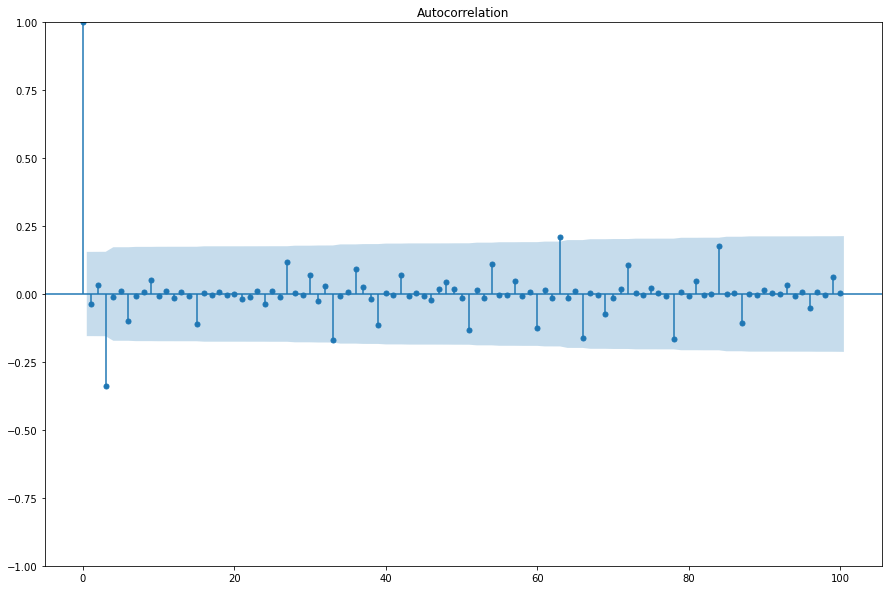

In [59]:
plot_acf(train_diff2, alpha=0.05,lags=100)
plt.show()

# Auto ARIMA

In [60]:
seq_models=auto_arima(train["Real GDP"],
                      start_p=1,start_q=1,d=1,
                      max_p=5,max_q=5,max_d=4,
                      start_P=0,max_P=2,start_Q=0,max_Q=2,D=0,max_D=2,
                      stepwise=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.494, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1556.317, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1395.058, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1467.269, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1621.425, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1396.262, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1397.889, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1399.596, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.315 seconds


In [61]:
# Checking the peformance of the best model given by ARIMA(1,0,2)

In [62]:
ar1ma0=ARIMA(train["Real GDP"], order=(1,1,0)).fit()
ar1ma0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Real GDP   No. Observations:                  162
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -697.798
Date:                Mon, 30 Jan 2023   AIC                           1399.596
Time:                        21:06:26   BIC                           1405.759
Sample:                             0   HQIC                          1402.098
                                - 162                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8661      0.041     20.875      0.000       0.785       0.947
sigma2       338.0239     20.798     16.253      0.000     297.260     378.787
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               233.23
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.52
Prob(H) (two-sided):                  0.92   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
y_hat['AR1MA0_Forecast']=ar1ma0.forecast(steps=len(valid))

In [64]:
y_hat.head()

,Date,Real GDP,SES Forecasted Values,SES Forecasted Values with mentioned alpha,TES_add_mul,AR1MA0_Forecast
162,2017-07-31,17075.837826,17030.878164,17030.664119,17078.450177,17067.593092
163,2017-08-31,17120.585652,17030.878164,17030.664119,17118.132664,17099.207037
164,2017-09-30,17163.890000,17030.878164,17030.664119,17159.164683,17126.586678
165,2017-10-31,17202.542283,17030.878164,17030.664119,17196.698695,17150.299149
166,2017-11-30,17239.947717,17030.878164,17030.664119,17233.228106,17170.835622


In [65]:
print("MAPE: ",mean_absolute_percentage_error(valid["Real GDP"],y_hat["AR1MA0_Forecast"]))
print("RMSE: ",sqrt(mean_squared_error(valid["Real GDP"],y_hat["AR1MA0_Forecast"])))

MAPE:  0.011122194481355933
RMSE:  238.83522881025564


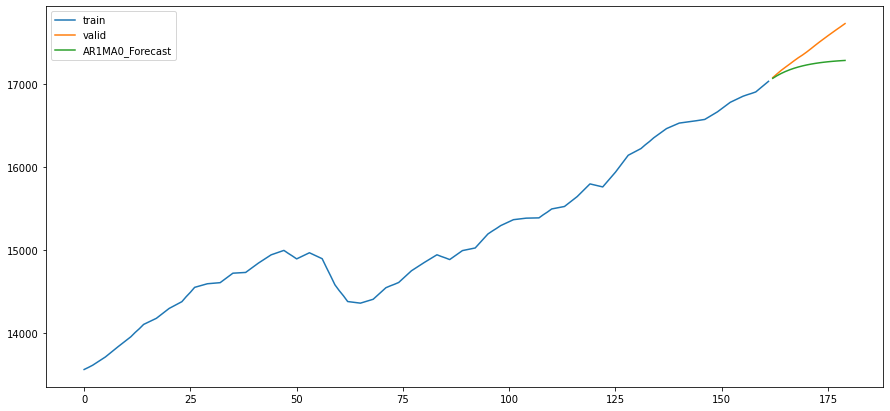

In [66]:
plt.figure(figsize=(15,7))
plt.plot(train["Real GDP"], label='train')
plt.plot(valid["Real GDP"], label='valid')
plt.plot(y_hat['AR1MA0_Forecast'], label='AR1MA0_Forecast')
#plt.plot(y_hat['Holt_linear_damped'], label='Holt linear damped')
plt.legend(loc='best')
plt.show()

In [67]:
# results

**From the above Experiments, It is found that Triple Exponential Smoothing is Performing Better than all other methods. We are using Triple Exponential Smoothing Method to forecast the test data**

>**TES Model Performance on Test data**

In [68]:
#using train and validation data for training itself
TrainPlusValid = data.iloc[:180]

In [69]:
#From Dec-2018 to Dec-2022 for forecasting
Test = data.iloc[180:]

In [70]:
Test.head()

,Date,Real GDP
180,2019-01-31,17762.639556
181,2019-02-28,17794.080444
182,2019-03-31,17828.890000
183,2019-04-30,17862.400989
184,2019-05-31,17897.029011


In [71]:
#TES on Test data

In [72]:
min_rmse=1000000

In [73]:
s_level=np.linspace(0,1,10)
s_slope=np.linspace(0,1,10)
d_trend=np.linspace(0,1,10)
s_seasonal=np.linspace(0,1,10)

In [74]:
y_hat = Test.copy()

In [75]:
# Fitting and testing the model with The best parameters.
model = ExponentialSmoothing(np.asarray(TrainPlusValid["Real GDP"]), seasonal_periods=8, trend='add',damped_trend=True, seasonal='mul')
fit1 = model.fit(smoothing_level=0.2222222222222222, smoothing_slope=1.0,damping_trend=1.0, smoothing_seasonal=0.2222222222222222, optimized=False)
y_hat['TES_add_mul_Test'] = fit1.forecast(len(Test))
y_hat.head()

,Date,Real GDP,TES_add_mul_Test
180,2019-01-31,17762.639556,17768.940648
181,2019-02-28,17794.080444,17794.060402
182,2019-03-31,17828.890000,17821.222218
183,2019-04-30,17862.400989,17855.480387
184,2019-05-31,17897.029011,17889.766498


In [76]:
# Plotting the forecast on along with Test Data

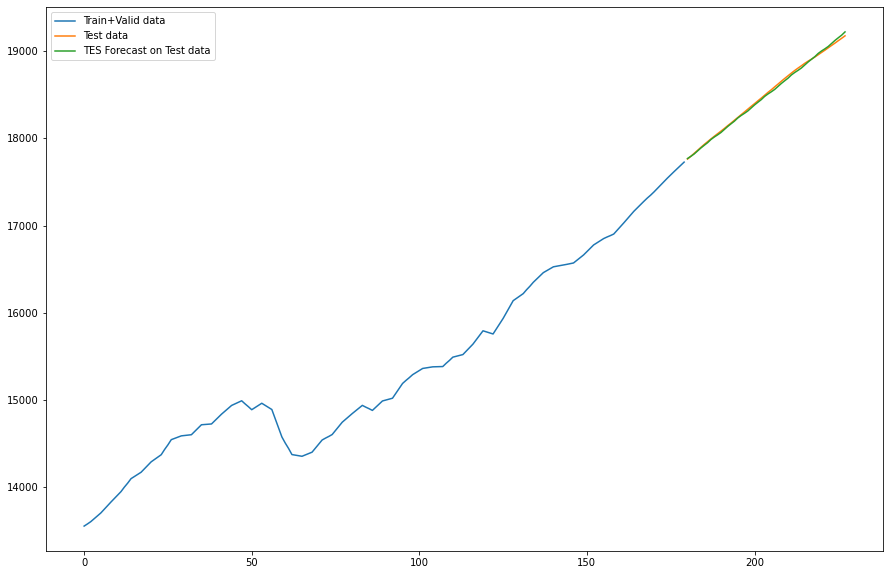

In [77]:
plt.figure(figsize=(15,10))
plt.plot(TrainPlusValid["Real GDP"],label="Train+Valid data")
plt.plot(Test["Real GDP"],label="Test data")
plt.plot(y_hat["TES_add_mul_Test"],label="TES Forecast on Test data")
plt.legend()

In [78]:
# Check the RMSE , MAE and MAPE, The values are lower than our benchmark model

In [79]:
#Error Metrics
rmse=sqrt(mean_squared_error(Test["Real GDP"], y_hat['TES_add_mul_Test']))
mae=(mean_absolute_error(Test["Real GDP"], y_hat['TES_add_mul_Test']))
mape=(mean_absolute_percentage_error(Test["Real GDP"], y_hat['TES_add_mul_Test']))

In [80]:
ar1ma0=ARIMA(TrainPlusValid["Real GDP"], order=(1,1,0)).fit()
ar1ma0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Real GDP   No. Observations:                  180
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -767.013
Date:                Mon, 30 Jan 2023   AIC                           1538.025
Time:                        21:06:27   BIC                           1544.400
Sample:                             0   HQIC                          1540.610
                                - 180                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8799      0.038     23.407      0.000       0.806       0.954
sigma2       306.4122     17.013     18.010      0.000     273.067     339.757
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               346.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.53
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
Test['AR1MA0_Forecast']=ar1ma0.forecast(steps=len(Test))

In [82]:
Test.head()

,Date,Real GDP,AR1MA0_Forecast
180,2019-01-31,17762.639556,17760.177128
181,2019-02-28,17794.080444,17788.639615
182,2019-03-31,17828.890000,17813.683976
183,2019-04-30,17862.400989,17835.720701
184,2019-05-31,17897.029011,17855.110986


In [83]:
print("MAPE: ",mean_absolute_percentage_error(Test["Real GDP"],Test["AR1MA0_Forecast"]))
print("RMSE: ",sqrt(mean_squared_error(Test["Real GDP"],Test["AR1MA0_Forecast"])))

MAPE:  0.028775697363032763
RMSE:  656.1323882171598


In [84]:
mape1=mean_absolute_percentage_error(Test["Real GDP"],Test["AR1MA0_Forecast"])
rmse1 =sqrt(mean_squared_error(Test["Real GDP"],Test["AR1MA0_Forecast"]))

In [85]:
df_date=data['Date']
train_date = data['Date'][:162]
valid_date = data['Date'][162:180]
test_date = data['Date'][180:]
train_valid_date= data['Date'][:180]

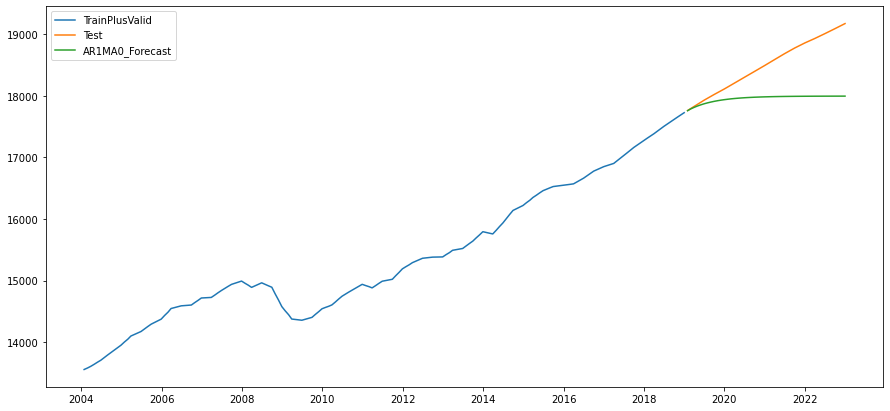

In [86]:
plt.figure(figsize=(15,7))
plt.plot(train_valid_date,TrainPlusValid["Real GDP"], label='TrainPlusValid')
plt.plot(test_date,Test["Real GDP"], label='Test')
plt.plot(test_date,Test['AR1MA0_Forecast'], label='AR1MA0_Forecast')
#plt.plot(y_hat['Holt_linear_damped'], label='Holt linear damped')
plt.legend(loc='best')
plt.show()

In [87]:
#Printing the test results through MAPE & RMSE
Results= pd.DataFrame({"Method" : ["TES","AR1MA0"], "RMSE": [rmse,rmse1], "MAPE (%)": [mape*100,mape1*100]},index=["TES","AR1MA0"])
Results

,Method,RMSE,MAPE (%)
TES,TES,19.214648,0.089622
AR1MA0,AR1MA0,656.132388,2.877570


## Conclusion- We are getting a mape of 2.87 percent for our test predictions from ARIMA

## Our Best Model is Triple Exponential Smoothing with the test mape of 0.08 percent